# Analyse and comparision of recomender systems algorithms

I analysed 3 different algorithms for recomender systems. Firstly, most basic algorithm - user user colaborative filtering, with cosine similarity measure and weighted average. Second was Funk singular value decomposition algorithm, presented at netflix prize in 2009. And third one was slope one, with weighted average. I checked how well all three of them are doing based on time needed and mean square error. Lastly I picked the best one and analysed it somehow deeper, with custom made measure of wellness. I also tried to somehow analyse time complexity of this algorithms, keeping in mind that numpy and numba magic could and probably would interupt results, but general relation of time given variables should been kept.

## User user colaborative filtering

User user collaborative filtering algorithm idea is to take movie which user did not rated, find similiar users to him who rated this movie (how much of this similiar users we will take is hyperparameter), take their weighted average of ratings of this movie (weight is cosine distance beetwen our user and them) and this is our rating of movie for user.
Beacuse we are doing for every cell which rating we want to predict, time complexity will be:
- number of test cases
- log(movies) beacuse I mapped each movie to users who rated it
- O(1) I treat cosine distance as one operation (numpy magic)
- k * n or nlogn beacuse we need to find minimum k times and every user could rated this movie, or just sort users by their cosine distance (in my implementation it is k * n)
- k beacuse we compute weighted average for k nearest users

And this gives us O(number_of_test_cases * log(movies) * k * n * k), worst case scenario, realistically n should around 1/100 * n beacuse in 10m dataset we have density around 1%.
Lowest MSE which I got was at level 1.06 which is around 2.5 times better than random recomendation, and time to compute just first 200 test cases was 140 seconds on 10m dataset and 11seconds to compute all 20k test cases on 100k data set. 140 seconds for 1/10000 of test set is little bit too slow for algorithm.

## Funk svd

Funk svd basic idea is to decompose matrix M of size n x m to two matrixes P (size n x k) and Q (m x k) which will correspond to users and items. We also try to include some user/movie specific bias and global bias to our predictions. So our prediction of rating will be given by:
#### r[i][j] =  P[i].dot(Q[j]) + user_bias[i] + item_bias[j] + global_bias
And we will try to estimate P,Q,user_bias and item_bias so we minimize our loss function:
#### sum_over_i,j (M[i][j] - P[i].dot(Q[j]) + user_bias[i] +item_bias[j] +global_bias)^2 + reg*(||P||^2+||Q||^2+user_bias^2+item_bias^2)
Little bit lower I wrote how to update each vector/matrix in every iteration of algorithm.

Time complexity of this algorithm is:
- number of iterations
- number of known cells (we are doing update for each cell seperately)
- k (we are doing for loop for i in range(k))

And prediciting after that is just O(number_of_test_cases). It is really fast algorithm (500 seconds on 10m dataset), which gives 0.63 MSE (nearly 2 times better than user user) without hardcore tuning of hyperparameters. Only downside of this algorithm are three hyperparameters to tune in comparision to one in user user colab.

## Slope one

Slopne one basic idea is to take movie which is not rated by user, and rate it by weighted average of differences beetwen this movie and another movies which another users rated (and our user) where weight is number of users who rated both movies. So for example if:
- user A rated movie "Toy story" with 4, "Monty Python" with 2 and we want to know how he will rate "Pokemon" 
- we take user B who rated "Toy story" with 3 and "Pokemon" with 4 and "Monty Python" with 5
- and user C who rated "Toy Story" with 4 and "Pokemon" with 1
- "Pokemons" are generally rated 1 mark lower than "Toy Story" -> ((4-3) + (1-4))/2 = -1
- "Pokemons" are generally rated 1 mark lower than "Monty Python" -> (4-5)/1 = -1
- so user A will probably rate "Pokemon" with rating ((4-1) * 2 + (2-1) * 1)/3 = 2.333

So firstly we construct matrix of size movies x movies, compute differences beetwen ratings of movies, and then we predict ratings by using this matrix. Time complexity of it will be:
- number of movies * number_of_movies * number_of_users (constructing matrix of differences)
- number of test cases * number_of_users (for each test case we need to look for all movies which user rated)

So mainly first part of algorithm is slow (20 hours on 10m dataset but using cython and some tricks suprise package achives this same thing in something beetwen 1000-3000 seconds, more about surprise later), but it gets 0.73 MSE which is somehow good score. And one thing which is also worth noticing is that there are no hyperparameters to tune.

## Comparision of my implementation with surprise (package of recomender systems algorithms)

#### Funk svd:
- mse:
    - my 0.6360918021837733
    - surprise 0.6366
- time:
    - my 547s
    - surprise 468s

#### Slope One
- mse:
    - my 0.8879477416535028
    - surprise 0.7407
- time:
    - my 20h
    - surprise 1000s-3000s

So about slope one, I checked implementation of it in surprise package, and algorithm is really similiar, so speed up is probably achived by the fact that they are using cython.

## Somehow deeper analyse of my funk svd

So mse is nice, it is easy and fast to compute, but it shows how well we are doing in predicting ratings after hiding some of them, not necessarily how well we recomend movies. So I constructed another measure function which will check how much user likes each movie category (another thing is that this is interesting info which probably can be used to another approach of recomender systems) then I will recomend to user some movies using svd and see how much of these recomendations have higher "category liking" score than movies which user already saw.

So firstly we map each movie to categories, then we construct matrix C of size number_of_movies x number_of_categories with 1 in cell i,j if movie i is from category j and 0 otherwise. Then we create matrix U of size number_of_users x number_of_categories by computing F for every user and every movie that this user liked.
Function F is defined as follows:
- bias is average of ratings given by user
- if user u rated movie c higher or equal 3 then multiplier for movie is 1+(movie_rating-bias)
- if user u rated movie c lower than 3 then multiplier for movie is -(1-(movie_rating-bias))
- U[u] += C[c] * multiplier

At the end of this we have matrix U filled with estimated likings of categories by each user. Now for each movie that user watched we can compute "category score" for this movie which is simply U[u].dot(C[c]) divided by number of categories that movie represents. We take average of these "category scores" for each user and then we recommend 10 movies for each user, compute their "category scores" and check if their score is higher than mean.
Funk svd gets 69% with this measure, which i think is pretty great - 69% movies which we are recommending should be interesting for user, well in terms of movies categories.

## Future predicting score of svd

Hiding random cells of matrix M is okey idea for testing algorithm but better approach would be hiding x% of newest ratings, and then checking MSE. After doing it, funk svd MSE is getting worse, from 0.63 to 1.17, what sugest that is harder to predict future than predicting random cells.

# Before running code

This notebook should be in the same folder as movielens 100k and 10m folders.
I use pd.read_csv("ml-100k/u.data"),pd.read_csv("ml-10M100K/ratings.dat) and pd.read("ml-10M100K/movies.dat") so paths to this files from jupyter notebook should be exactly the same.

In [2]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import surprise
from numba.typed import Dict
from numba import types
import numba
from numba import jit
from time import time
from numba import prange

# Data loading and preprocessing

In [6]:
#So I will use 100k dataset for general fast experimentation and 10m for real comparision of algorithms
data_100k = pd.read_csv("ml-100k/u.data",header = None,names = ['user','movie','rating','timestamp'],sep = "\t")
data_10m = pd.read_csv("ml-10M100K/ratings.dat",header = None,names = ["user","movie","rating","timestamp"],sep = "::",encoding = "utf8",engine = "python")

In [7]:
data_100k = data_100k.drop('timestamp',axis=1)
data_10m = data_10m.drop('timestamp',axis=1)

In [8]:
data_100k = data_100k.to_numpy()
data_10m = data_10m.to_numpy()

In [9]:
#so in 10m dataset movies ids are from range 1 to 65133 but we have data about only 10677 of them so we need to map
#their id, (in dataset there is for example movie id 4001 and next one has id 4021 when they should be x and x+1)
@njit
def hash_movies(data):
    table = dict()
    reversed_table = dict()
    cnt = 0
    for ite in range(data.shape[0]):
        if not data[ite][1] in table:
            table[data[ite][1]] = cnt
            reversed_table[cnt] = data[ite][1]
            cnt+=1
        data[ite][1] = table[data[ite][1]]
    return (table,reversed_table)

tables_10m = hash_movies(data_10m)
data_100k[:,1] = data_100k[:,1] - 1

In [10]:
shuffled_data_100k = np.random.permutation(data_100k)
train_100k,test_100k = np.split(shuffled_data_100k,[int(0.8*data_100k.shape[0])])
test_100k[:,0] = test_100k[:,0] - 1
shuffled_data_10m = np.random.permutation(data_10m)
train_10m,test_10m = np.split(shuffled_data_10m,[int(0.8*data_10m.shape[0])])
test_10m[:,0] = test_10m[:,0] - 1

In [11]:
@njit
def construct_Matrix(data,users_num,items_num):
    matrix = np.ones((users_num,items_num))
    matrix[:] = np.nan
    for row in range(data.shape[0]):
        matrix[int(data[row][0]-1),int(data[row][1])] = data[row][2]
    return matrix

train_100k_mat = construct_Matrix(train_100k,943,1682)
train_10m_mat = construct_Matrix(train_10m,71567,10681)
data_100k_mat = construct_Matrix(data_100k,943,1682)
data_10m_mat = construct_Matrix(data_10m,71567,10681)

In [12]:
#well making it function speed it up more than 4 times (average time for on 10m without njit was 30sec and 7sec with njit)
@njit
def global_mean(original_matrix):
    return np.nanmean(original_matrix)

global_bias_100k = global_mean(train_100k_mat)
global_bias_10m = global_mean(train_10m_mat)

# Random recomendation

In [9]:
#just to have some reference
m_100k = 0
m_10m = 0
for i in range(100):
    rng_100k = np.random.uniform(1,5,test_100k.shape[0])
    rng_10m = np.random.uniform(1,5,test_10m.shape[0])
    m_100k += np.mean((test_100k[:,2]-rng_100k)**2)
    m_10m += np.mean((test_10m[:,2]-rng_10m)**2)
print("MSE 100k: ",m_100k/100)
print("MSE 10m: ",m_10m/100)

MSE 100k:  2.876282853876754
MSE 10m:  2.7207939092634303


# User-user collaborative filtering

Basic idea of user-user collaborative filtering is:
1. we want to rate movie y for user x
2. so we take every user who rated movie y and measure their similarity to user x
3. after that we take k most similar to user x users and compute their weighted average of ratings of movie y
4. this is our predicted rating of user x on movie y

In [10]:
#so here we are remembering for each item which user rated it, it will speed up filtering
@njit
def remember_users(original_matrix,rem_user):
    for y in range(original_matrix.shape[1]):
        ar = []
        for x in range(original_matrix.shape[0]):
            if not np.isnan(original_matrix[x][y]):
                ar.append(x)
        arr = np.array(ar)
        if arr.size != 0:
            rem_user[y] = arr

rem_user_100k = Dict.empty(key_type = types.int64,value_type = types.int64[:])
rem_user_10m = Dict.empty(key_type = types.int64,value_type = types.int64[:])
remember_users(train_100k_mat,rem_user_100k)
remember_users(train_10m_mat,rem_user_10m)

In [11]:
#function to copy original_matrix and fill copied matrix rows with means for each row (means for user)
@njit
def mean_user(original_matrix,replacer = 0):
    new_matrix = np.copy(original_matrix)
    for row in range(new_matrix.shape[0]):
        bias = np.nanmean(new_matrix[row,:])
        if np.isnan(bias):
            bias = replacer
        new_matrix[row][np.isnan(new_matrix[row,:])] = bias
    return new_matrix

In [12]:
train_100k_mat_user = mean_user(train_100k_mat,global_bias_100k)
train_10m_mat_user = mean_user(train_10m_mat,global_bias_10m)

In [13]:
#well there was a choice, no for just smart numpy matrix operations or njit and for, after some tests I choosed njit
#mainly beacuse njit funcs can only call njit funcs so after running smart numpy vs not so smart numpy with njit
#the champion was clearly njit
@njit
def cosinus_ratio(me,neighbour):
    arr = []
    for i in range(neighbour.shape[0]):
        arr.append(np.dot(me,neighbour[i,:])/(np.linalg.norm(me)*np.linalg.norm(neighbour[i,:])))
    return np.array(arr)

@njit
def get_std_user(original_matrix,neighbours,user,y_axis,k,weighted = True):
    similarities = cosinus_ratio(user,neighbours)
    #indices = np.argsort(similarities)
    #indices = indices[:k]
    simi = np.copy(similarities)
    indi = []
    k = min(k,simi.size)
    for i in range(k):
        smallest = np.argmax(simi)
        indi.append(smallest)
        simi[smallest] = -100
    indices = np.array(indi)
    mean = 0
    weights = 0
    for neighbour in indices:
        if weighted:
            mean += neighbours[neighbour,y_axis]*similarities[neighbour]
            weights += similarities[neighbour]
        else:
            mean+= neighbours[neighbour,y_axis]
    if weighted:
        return mean/weights
    else:
        return mean/k
    
@njit
def user_user_colab(original_matrix,test,rem_user,k,weighted=True,replacer = 0):
    ratings = []
    for i in range(test.shape[0]):
        user_x = test[i][0]
        item_y = test[i][1]
        if not item_y in rem_user:
            ratings.append(replacer)
        else:
            res = get_std_user(original_matrix,original_matrix[rem_user[item_y],:],original_matrix[user_x,:],item_y,k,weighted)
            ratings.append(res)
    return np.array(ratings)

11.437665491104125


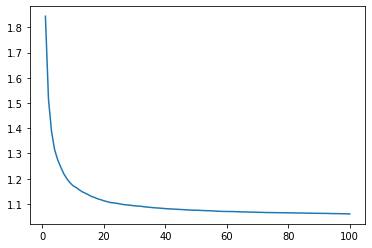

In [14]:
#okay so few things about user-user-colab, it takes 12 seconds for 20k questions on roughly 1000x1600 matrix
#that is 0.0006s for one question
#let n be number of users and m number of movies
#for every question it needs to ask dictionary (log(m) complexity) then compute cosine for each user who rated
#that movie - O(n) (if we say that cosinus_ratio complexity is O(1)),then finding k biggest is k*n for argmax
#or nlogn for argsort so in total we have single question complexity is something like log(m)*n*log(n)*n
#we have sparse data so we can divide it by 100 or even more probably (there wont be a lot of users who all
#rated some movie), but even though it is still (n^2)*logn*logm for question - really slow
#yes of course there is magic numpy matrix stuff but I treated matrix calculations as O(1) complexity
#even if we change asking each user who rated movie complexity from O(n) to O(1) it will still be n*logn*logm
#but it is still time for single question!
#results are not really bad MSE at level 1.3 is not best but also not worst result we could have
#better than random that is for sure (but also much much slower)
test_100k_user = test_100k[:,:2].astype(int)
MSE = []
av_time = 0
for k in range(1,101):
    a = time()
    result_100k = user_user_colab(train_100k_mat_user,test_100k_user,rem_user_100k,k,True,global_bias_100k)
    av_time += time() - a
    MSE.append(np.mean((test_100k[:,2]-result_100k)**2))
print(av_time/100)
plt.plot(np.arange(1,101,1),MSE)
plt.show()

In [15]:
print("Lowest MSE: ",np.min(MSE))

Lowest MSE:  1.0604523846286376


In [16]:
#so lets see how horrible it gets at 10m movie lens dataset, it takes 200 seconds for 200 question on 70000x10000 
#matrix, it is 1 second for one question!
#70000*log2(70000)*log2(10000)/1000*log2(1000)*log2(1600) = 140
#0.0006*140=0.084 so time complexity of user-user is even bigger than n*logn*logm
#2m questions with speed 1question/1s is 23,14 days.
#So conclusion is that user-user colab is pretty bad approach, even though it gets somehow fine MSE score, it is worth
#noticing that MSE score got better with data increase
test_10m_user = test_10m[:,:2].astype(int)
test_10m_user_200sample = test_10m_user[:200,:]
a = time()
result_10m_200sample = user_user_colab(train_10m_mat_user,test_10m_user_200sample,rem_user_10m,10,True,global_bias_10m)
print(time()-a)
print("MSE: ",np.mean((test_10m[:200,2]-result_10m_200sample)**2))
print("MAE: ",np.mean(np.abs(test_10m[:200,2]-result_10m_200sample)))

141.53783869743347
MSE:  1.078460268100709
MAE:  0.7962495546980602


# Funk SVD

Basic idea of funk singular value decomposition is:
1. We want to express our ratings matrix M of shape n x m, as P.dot(Q) where P is matrix of shape n x k and each of n rows coresponds to some numbers describing user n, and Q is analogically movies matrix with this same properties as P.
2. Another thing which we want is computing P and Q in a way that M-P.dot(Q) is minimal on known cells.
3. We also introduce global bias and biases for each user and item to somehow solve problem of users rating everything high and users rating everything low
4. Then P.dot(Q) will give us some approximation of matrix M (now we have each cell filled) and hopefully good one.
5. More formally:
    1. We have:
        - gb = np.nanmean(M)
        - bu = np.zeros(n)
        - bi = np.zeros(m)
        - P = np.random.normal(n,k)
        - Q = np.random.normal(m,k)
        - E[u][i] = gb+bu[u]+bi[i]+ for f in range(k): P[u][f]*Q[i][f]
    2. The learning step is for each known rating update biases,P and Q as follows:
        - ERR[u][i] = M[u][i]-E[u][i]
        - Bu[u] = Bu[u] + lr*(ERR[u][i] - reg * Bu[u])
        - Bi[i] = Bi[i] + lr*(ERR[u][i] - reg * Bi[u])
        - P[u][f] = P[u][f] + lr * (ERR[u][i] * Q[i][f] - reg * P[u][f])
        - Q[i][f] = Q[i][f] + lr * (ERR[u][i] * P[u][f] - reg * Q[i][f])
        - lr is learning rate and reg is regularization

In [22]:
@njit
def matrix_factorize_funk(iterations,original_matrix,non_nan,global_bias,user_bias,item_bias,learning_rate,regularization,size,users,items):
    for cnt in range(iterations):
        non_nan = np.random.permutation(non_nan)
        count = 0
        for non in range(non_nan.shape[0]):
            non0 = non_nan[non][0]
            non1 = non_nan[non][1]
            if np.isnan(original_matrix[non0][non1]):
                print("ERROR")
                return None
            estimate = global_bias + user_bias[non0] + item_bias[non1]
            for lat in range(size):
                estimate += users[non0,lat] * items[non1,lat]
            err = original_matrix[non0,non1] - estimate
            user_bias[non0] += learning_rate * (err - regularization * user_bias[non0])
            item_bias[non1] += learning_rate * (err - regularization * item_bias[non1])
            for lat in range(size):
                usf = users[non0,lat]
                itf = items[non1,lat]
                users[non0,lat] += learning_rate * (err * itf - regularization * usf)
                items[non1,lat] += learning_rate * (err * usf - regularization * itf)
            count+=1
    return (users,items)

In [18]:
#so funk svd is doing great, at least compared to user user collaborative filtering, total speed of 562 second for 
#anwsering 2M questions, well 512 seconds for being able to anwser any question about matrix, MSE is two times better
#than user user colab, generally much better than user user. So first of all speed increase is due to fact that 
#complexity of algorithm is linearly proportional to number of known cells - which is much smaller than user*movies,
#even smaller than user*log(movies). Second thing is that we include some global,user and movie biases to somehow
#include generall tendency of rating high or low for each user, and generall tendency of being rated high if movie
#is great,and rated low if movie is bad no matter of users preferences. Well only downside of funk svd is that
#we need to set number of iterations,learning rate,regularization rate and size of matrixes, four hyperparameters to
#choose and tune is much more than just one in user user colab
bias_user = np.zeros(train_10m_mat.shape[0])
bias_item = np.zeros(train_10m_mat.shape[1])
non_nan = train_10m[:,:2]
non_nan[:,0] -= 1
non_nan = non_nan.astype(int)
size = 15
users = np.random.normal(scale = 0.1,size = [train_10m_mat.shape[0],size])
items = np.random.normal(scale = 0.1,size = [train_10m_mat.shape[1],size])
a = time()
factorized_funk_10m = matrix_factorize_funk(100,train_10m_mat,non_nan,global_bias_10m,bias_user,bias_item,0.001,0.005,size,users,items)
print(time()-a)

497.337769985199


In [19]:
a = time()
res_10m = np.dot(factorized_funk_10m[0],factorized_funk_10m[1].T)
tes = test_10m[:,:2].astype(int)
result_10m = []
for user_x,item_y in tes:
    if np.isnan(res_10m[user_x,item_y]):
        print(user_x,item_y)
    result_10m.append(global_bias_10m+bias_user[user_x]+bias_item[item_y]+res_10m[user_x,item_y])
result_10m = np.array(result_10m)
print(time()-a)
print("MSE: ",np.mean((test_10m[:,2]-result_10m)**2))

50.31415295600891
MSE:  0.6360918021837733


# Slope one

In [21]:
#dev_mat[i][j] is difference of ratings movie[i] - movie[j] so if i want to get rating for movie y i need
#sum over dev_mat[y][x] for every x
@jit(nopython=True,parallel=True)
def get_dev(original_matrix,dev_mat,dev_mat_user):
    for i in prange(original_matrix.shape[1]):
        if i%100==0:
            print(i/original_matrix.shape[1])
        for j in prange(original_matrix.shape[1]):
            if j==i:
                break
            for u in range(original_matrix.shape[0]):
                if not (np.isnan(original_matrix[u][i]) or np.isnan(original_matrix[u][j])):
                    dev_mat[i][j] += original_matrix[u][i] - original_matrix[u][j]
                    dev_mat[j][i] -= original_matrix[u][i] - original_matrix[u][j]
                    dev_mat_user[i][j] += 1
                    dev_mat_user[j][i] += 1

dev_mat_100k = np.zeros(shape=[train_100k_mat.shape[1],train_100k_mat.shape[1]])
dev_mat_100k_user = np.zeros(shape=[train_100k_mat.shape[1],train_100k_mat.shape[1]])
a = time()
get_dev(train_100k_mat,dev_mat_100k,dev_mat_100k_user)
print(time()-a)

0.0
0.059453032104637336
0.11890606420927467
0.7728894173602854
0.535077288941736
0.2972651605231867
0.178359096313912
0.356718192627824
0.5945303210463734
0.23781212841854935
0.8323424494649228
0.4161712247324614
0.6539833531510107
0.89179548156956
0.4756242568370987
0.713436385255648
0.9512485136741974
3.2142810821533203


In [22]:
@njit
def predict_slope_one(original_matrix,test,dev_mat,dev_mat_user,replacer):
    res = []
    for i in range(test.shape[0]):
        x = test[i][0]
        y = test[i][1]
        score = 0
        weights = 0
        for j in range(original_matrix.shape[1]):
            if (not np.isnan(original_matrix[x][j])) and j!=y:
                score += original_matrix[x][j]*dev_mat_user[y][j] + dev_mat[y][j]
                weights += dev_mat_user[y][j]
        if weights != 0:  
            res.append(score/weights)
        else:
            res.append(replacer)
    return np.array(res)

In [23]:
a = time()
res_slope_one_100k = predict_slope_one(train_100k_mat,test_100k[:,:2].astype(int),dev_mat_100k,dev_mat_100k_user,global_bias_100k)
print(time()-a)
print("MSE: ",np.mean((test_100k[:,2]-res_slope_one_100k)**2))

0.5318710803985596
MSE:  0.8879477416535028


In [24]:
#lets think about it for a second, 1.5 seconds on 1000x1600 matrix, in 10m dataset we have 70000x10000 matrix and
#our complexity for constructing dev matrix is m*m*n so on 10m dataset we should work roughly 70*70*10 times longer
#73500 seconds and it is 20 hours in approximation...little bit too long
dev_mat_10m = np.zeros(shape=[train_10m_mat.shape[1],train_10m_mat.shape[1]])
dev_mat_10m_user = np.zeros(shape=[train_10m_mat.shape[1],train_10m_mat.shape[1]])
a = time()
get_dev(train_10m_mat,dev_mat_10m,dev_mat_10m_user)
print(time()-a)

0.0
0.009362419249133976
0.018724838498267952
0.02808725774740193
0.25278531972661733
0.037449676996535904
0.04681209624566988
0.05617451549480386
0.06553693474393783
0.5055706394532347
0.07489935399307181
0.26214773897575133
0.08426177324220578
0.09362419249133976
0.10298661174047374
0.27151015822488533
0.7583559591798521
0.11234903098960772
0.12171145023874169
0.5149330587023687
0.2808725774740193
0.13107386948787567
0.14043628873700964
0.2902349967231533
0.14979870798614361
0.5242954779515027
0.1591611272352776
0.767718378428986
0.29959741597228723
0.16852354648441156
0.17788596573354554
0.30895983522142123
0.5336578972006366
0.1872483849826795
0.3183222544705552
0.1966108042318135
0.77708079767812
0.2059732234809475
0.5430203164497707
0.3276846737196892
0.21533564273008146
0.3370470929688231
0.22469806197921544
0.5523827356989046
0.2340604812283494
0.786443216927254
0.3464095122179571
0.24342290047748338
0.3557719314670911
0.5617451549480386
0.3651343507162251
0.795805636176388
0.5

In [25]:
a = time()
res_slope_one_10m = predict_slope_one(train_10m_mat,test_10m[:,:2].astype(int),dev_mat_10m,dev_mat_10m_user,global_bias_10m)
print(time()-a)
print("MSE: ",np.mean((test_10m[:,2]-res_slope_one_10m)**2))

129.95820689201355
MSE:  0.7350576486037158


# Surprise algorithms

In [26]:
from surprise import SVD as SVDs
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SlopeOne
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
data2 = pd.read_csv("ml-10M100K/ratings.dat",header = None,names = ["user","movie","rating","timestamp"],sep = "::",encoding = "utf8",engine = "python")
data2 = Dataset.load_from_df(data2[['user', 'movie', 'rating']], reader)

In [27]:
#Surprise SlopeOne uses cython version of numpy and have some little bit optimized functions, but in general it works
#the same way as my implementation
algo = SlopeOne()
cross_validate(algo, data2, measures=['MSE'], cv=5, verbose=True)

Evaluating MSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7408  0.7406  0.7400  0.7392  0.7429  0.7407  0.0012  
Fit time          214.46  228.06  222.59  229.80  224.76  223.93  5.36    
Test time         687.88  697.55  734.83  708.24  708.57  707.41  15.70   


{'test_mse': array([0.74080731, 0.74064798, 0.74002596, 0.73920154, 0.74286376]),
 'fit_time': (214.4570689201355,
  228.05578589439392,
  222.58541989326477,
  229.80457520484924,
  224.7646279335022),
 'test_time': (687.8847141265869,
  697.5467760562897,
  734.8269639015198,
  708.2431640625,
  708.5718669891357)}

In [28]:
algo = SVDs()
cross_validate(algo, data2, measures=['MSE'], cv=5, verbose=True)

Evaluating MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.6364  0.6365  0.6377  0.6367  0.6358  0.6366  0.0006  
Fit time          431.41  435.88  436.29  436.57  436.14  435.26  1.94    
Test time         35.99   36.96   31.07   27.10   36.57   33.54   3.86    


{'test_mse': array([0.63641685, 0.63645353, 0.63767043, 0.63674559, 0.63577264]),
 'fit_time': (431.41488099098206,
  435.88187885284424,
  436.29262113571167,
  436.5704970359802,
  436.1357898712158),
 'test_time': (35.991979122161865,
  36.96283984184265,
  31.070253133773804,
  27.101269006729126,
  36.572930097579956)}

# Funk SVD results analysis

In [20]:
#As could be seen,funk svd is doing the best out of all algorithms presented, but MSE when its nice to see some
#general wellness of algorithm and easy is to compute, it does not provide us most important anwsers.
#Recomender systems are meant to be used to recomend something to user based on their previous interactions
#so lets construct another measure of algorithm and see how good funk svd is doing.
@njit
def recomendations_for_users(data,x,pu,qi,bu,bi,gb):
    recomendations = []
    for y in range(data.shape[1]):
        if np.isnan(data[x][y]):
            recomendations.append(((pu[x,:].dot(qi[y,:]))+bu[x]+bi[y]+gb,y))
    recomendations.sort()
    return recomendations

In [21]:
#firstly we will pick user, print out using movie.dat categories of his favourite movies,make some recomendations,
#and see how good our recomendations fit in
pu = factorized_funk_10m[0]
qi = factorized_funk_10m[1]
bu = bias_user
bi = bias_item
gb = global_bias_10m
recomendations = recomendations_for_users(data_10m_mat,0,pu,qi,bu,bi,gb)

In [22]:
print(recomendations[-3:])

[(5.5009287536741835, 5941), (5.513155338175091, 235), (5.543432974113515, 3296)]


In [23]:
movie_data = pd.read_csv("ml-10M100K/movies.dat",header = None,names = ["id","title","category"],sep = "::",encoding = "utf8",engine = "python")

In [24]:
#at first my if statement was >=4 but after some thought, every movie which is rated higher than user bias is supposed
#to be movie liked by him/her
@njit
def find_best_user_movies(original_matrix,user):
    movies_that_user_liked = []
    user_bias = np.nanmean(original_matrix[user])
    for y in range(original_matrix.shape[1]):
        if not np.isnan(original_matrix[0][y]):
            if original_matrix[0][y] >= user_bias:
                movies_that_user_liked.append(y)
    return movies_that_user_liked
            
movies_that_user_liked = find_best_user_movies(data_10m_mat,0)
print(movies_that_user_liked)
movies = []
for movie in movies_that_user_liked:
    movies.append(int(tables_10m[1][movie]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [25]:
movie_data.head()
for a in movies:
    print(movie_data.loc[movie_data['id']==a])

      id             title        category
120  122  Boomerang (1992)  Comedy|Romance
      id            title               category
183  185  Net, The (1995)  Action|Crime|Thriller
      id                 title category
228  231  Dumb & Dumber (1994)   Comedy
      id            title                      category
289  292  Outbreak (1995)  Action|Drama|Sci-Fi|Thriller
      id            title                 category
313  316  Stargate (1994)  Action|Adventure|Sci-Fi
      id                          title                       category
325  329  Star Trek: Generations (1994)  Action|Adventure|Drama|Sci-Fi
      id                    title                 category
351  355  Flintstones, The (1994)  Children|Comedy|Fantasy
      id                title                  category
352  356  Forrest Gump (1994)  Comedy|Drama|Romance|War
      id                    title                    category
358  362  Jungle Book, The (1994)  Adventure|Children|Romance
      id                  

In [26]:
best_ten = recomendations[-5:]
for mv in best_ten:
    print(movie_data.loc[movie_data['id']==int(tables_10m[1][mv[1]])])

        id                       title  \
1172  1197  Princess Bride, The (1987)   

                                     category  
1172  Action|Adventure|Comedy|Fantasy|Romance  
        id                     title                  category
6961  7075  Court Jester, The (1956)  Adventure|Comedy|Musical
        id                     title category
6867  6981  Word, The (Ordet) (1955)    Drama
        id                      title                 category
1242  1270  Back to the Future (1985)  Adventure|Comedy|Sci-Fi
        id                  title                          category
7878  8580  Into the Woods (1991)  Adventure|Comedy|Fantasy|Musical


In [27]:
#okay so now lets construct measure function for whole dataset,idea is as follows:
#map each category to number, create matrix users x moviecategories, where cell describes how much user likes this
#category, where equation for it will be:
#if movie_rating is higher than 3 then 1+(movie_rating-bias)
#if movie_rating is lower than 3 then -(1-(movie_rating-bias))
#after that after we make recomendation we look up in our newly created matrix to check if categories of our movie
#match favourite categories of user
mapping = {}
cnt = 0
movie_data_mat = np.zeros(shape = [10681,20])
for index,row in movie_data.iterrows():
        categories = row[2].split('|')
        for category in categories:
            if not category in mapping:
                mapping[category] = cnt
                cnt+=1
            if not row[0] in tables_10m[0]:
                tables_10m[0][row[0]] = max(tables_10m[0].values())+1
            x = tables_10m[0][row[0]]
            y = mapping[category]
            movie_data_mat[x,y] = 1
print(len(mapping.keys()))

20


In [28]:
#well I tried drawing and imagining a lot of functions to properly describe user_likings but they either had a problem
#of users having only 5 and then his liking would be 0, or user giving only 1 and these funcs would not take this
#movies as not liked beacuse user_bias would be 1. So I decided to use linearly growing with distance from bias 
#multiplier, beacuse well it is simply and somehow captures all of this.
@njit
def create_user_like_mat(original_matrix,users_likings):
    for user in range(original_matrix.shape[0]):
        bias = np.nanmean(original_matrix[user])
        for movie in range(original_matrix.shape[1]):
            if not np.isnan(original_matrix[user,movie]):
                if original_matrix[user,movie] >= 3:
                    users_likings[user]+=(1+(original_matrix[user][movie]-bias)) * movie_data_mat[movie]
                else:
                    users_likings[user]-=(1-(original_matrix[user][movie]-bias)) * movie_data_mat[movie]

users_likings = np.zeros(shape = [71567,20])
create_user_like_mat(data_10m_mat,users_likings)

In [29]:
print(data_10m_mat[1],np.nanmean(data_10m_mat[1]))
print(users_likings[1])

[nan nan nan ... nan nan nan] 3.2
[10.   0.   0.8  3.2  0.8  0.2  3.6 13.2 -2.2  2.6  0.8 -2.2  7.8  0.
  0.   4.4  0.8  0.   2.8  0. ]


In [30]:
@njit
def user_likings_eval_bias(original_matrix,users_likings_bias,users_likings,movie_data_mat):
    empty_users = 0
    for user in range(original_matrix.shape[0]):
        cnt = 0
        for movie in range(original_matrix.shape[1]):
            if not np.isnan(original_matrix[user,movie]):
                users_likings_bias[user] += users_likings[user].dot(movie_data_mat[movie])/(np.sum(movie_data_mat[movie]))
                cnt+=1
        if cnt==0:
            empty_users +=1
            users_likings_bias[user] = np.nan
        else:
            users_likings_bias[user] /= cnt
    return empty_users

users_likings_bias = np.zeros(shape = [71567])
empty_users = user_likings_eval_bias(data_10m_mat,users_likings_bias,users_likings,movie_data_mat)
print(empty_users)
users_likings_bias

1689


array([ 7.18409091,  6.36233333, 11.32082185, ..., 37.72640892,
       16.08540192, 10.20271746])

In [31]:
@njit
def find_category_deviation(original_matrix,users_likings,users_likings_bias,movie_data_mat,tables,pu,qi,bu,bi,gb):
    general_score = 0
    cnt = 0
    for user in range(original_matrix.shape[0]):
        if user%1000==0:
            print(user/original_matrix.shape[0])
        if np.isnan(np.nanmean(original_matrix[user])):
            continue
        recomend = recomendations_for_users(original_matrix,user,pu,qi,bu,bi,gb)
        recomendations = recomend[:-10]
        for r in range(len(recomendations)):
            categories = movie_data_mat[recomendations[r][1]]
            indexes = (categories == 1)
            row = users_likings[user]
            res = np.sum(row[indexes])
            cnt+=1
            if res >= users_likings_bias[user]:
                general_score+=1
    return general_score/cnt

find_category_deviation(data_10m_mat,users_likings,users_likings_bias,movie_data_mat,tables_10m,pu,qi,bu,bi,gb)

0.0
0.013972920480109547
0.027945840960219095
0.04191876144032864
0.05589168192043819
0.06986460240054773
0.08383752288065728
0.09781044336076683
0.11178336384087638
0.12575628432098593
0.13972920480109546
0.15370212528120503
0.16767504576131456
0.18164796624142412
0.19562088672153366
0.20959380720164322
0.22356672768175276
0.23753964816186232
0.25151256864197186
0.2654854891220814
0.2794584096021909
0.2934313300823005
0.30740425056241005
0.3213771710425196
0.3353500915226291
0.3493230120027387
0.36329593248284825
0.3772688529629578
0.3912417734430673
0.4052146939231769
0.41918761440328645
0.43316053488339595
0.4471334553635055
0.4611063758436151
0.47507929632372464
0.48905221680383415
0.5030251372839437
0.5169980577640533
0.5309709782441628
0.5449438987242724
0.5589168192043819
0.5728897396844914
0.586862660164601
0.6008355806447105
0.6148085011248201
0.6287814216049297
0.6427543420850392
0.6567272625651488
0.6707001830452582
0.6846731035253678
0.6986460240054774
0.7126189444855869
0.

0.6895523294170799

# Future predicting using svd

In [13]:
data_10m_future = pd.read_csv("ml-10M100K/ratings.dat",header = None,names = ["user","movie","rating","timestamp"],sep = "::",encoding = "utf8",engine = "python")

In [14]:
data_10m_future = data_10m_future.to_numpy()

In [15]:
table = hash_movies(data_10m_future)

In [16]:
data_10m_future = data_10m_future.astype(int)

In [17]:
data_10m_future_all = data_10m_future[data_10m_future[:,3].argsort()]

In [18]:
data_10m_future_all

array([[     36955,         71,          3,  789652009],
       [     36955,        102,          5,  789652009],
       [     36955,        387,          3,  789652009],
       ...,
       [     63100,       1358,          2, 1231131142],
       [     62510,       2228,          2, 1231131303],
       [     62510,       4538,          3, 1231131736]])

In [51]:
train_10m_future,test_10m_future = np.split(data_10m_future_all,[int(0.8*data_10m_future_all.shape[0])])

In [52]:
train_10m_future_mat = construct_Matrix(train_10m_future,71567,10681)

In [53]:
global_bias_future = np.nanmean(train_10m_future_mat)
bias_user_future = np.zeros(train_10m_future_mat.shape[0])
bias_item_future = np.zeros(train_10m_future_mat.shape[1])
non_nan_future = train_10m_future[:,:2]
non_nan_future[:,0] -= 1
non_nan_future = non_nan_future.astype(int)
size = 100
users_future = np.random.normal(scale = 0.1,size = [train_10m_future_mat.shape[0],size])
items_future = np.random.normal(scale = 0.1,size = [train_10m_future_mat.shape[1],size])
a = time()
factorized_funk_10m_future = matrix_factorize_funk(20,train_10m_future_mat,non_nan_future,global_bias_future,bias_user_future,bias_item_future,0.005,0.02,size,users_future,items_future)
print(time()-a)

122.91508722305298


In [54]:
a = time()
res_10m_future = np.dot(factorized_funk_10m_future[0],factorized_funk_10m_future[1].T)
tes_future = test_10m_future[:,:2].astype(int)
result_10m_future = []
for user_x,item_y in tes_future:
    result_10m_future.append(global_bias_future+bias_user_future[user_x]+bias_item_future[item_y]+res_10m_future[user_x,item_y])
result_10m_future = np.array(result_10m_future)
print(time()-a)
print("MSE: ",np.mean((test_10m_future[:,2]-result_10m_future)**2))

38.70443296432495
MSE:  1.2245112498381525


In [48]:
from surprise import accuracy
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import SlopeOne
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0, 5))
train_10m_future_df = pd.DataFrame({'user':train_10m_future[:,0],'movie':train_10m_future[:,1],'rating':train_10m_future[:,2],'timestamp':train_10m_future[:,3]})
data_train_future = Dataset.load_from_df(train_10m_future_df[['user', 'movie', 'rating']], reader)
trainset = data_train_future.build_full_trainset()

In [49]:
algo_future = SVD()
a = time()
algo_future.fit(trainset)
print(time()-a)

404.9072380065918


In [50]:
preds = []
for row in test_10m_future:
    preds.append(row[2]-algo_future.predict(row[0],row[1],row[2])[3])
preds = np.array(preds)
print("MSE: ", np.mean(preds**2))

MSE:  1.1691525044047777
